# 01 - Project Introduction: *What are the Meteorological Seasons?*

In [1]:
# Basic imports
import os

# Plotting packages
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Geodata handlers
import xarray as xr
import geopandas as gpd
from shapely.geometry import mapping

from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results


font = {'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

## Case study region
The study area analyzed in this work is the Indian subcontinent with a focus on the Hindu-Kush Karakoram/Himalaya region (HKKH).

As we will see later the interesting features of this area are:
- Two different seasonal patterns are detectable in the same region.
- The features of one of the two seasonal pattern, the Indian Summer Monsoon, are deeply exploited in scientific literature.

--- 
### Boundaries data
The **administrative boundary data** are taken from [GADM](https://gadm.org/about.html), version 4.1. Data are distributed in GeoPackage format. Two different files are used:
- World: contains the first level (countries) for the entire world (*data/raw/external/GADM41_WORLD.gpkg*)
- India: contains the four administration levels of India (*data/raw/external/GADM41_IND.gpkg*)

The *administrative division of India* follows this scheme:
- Level 0: Country
- Level 1: States and union territories
- Level 2: District
- Level 3: Taluc

<sub><sup> *DISCLAIMER: Some regions in this area are disputed between states. The authors do not take responsibility for the borders shown, which are sourced from the GADM dataset.* </sup></sub>


In [2]:
# -- BOUNDARIES DATA
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1') # Layer 1 -> states
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')       # Layer 0 -> countries

--- 
### Orography data

The region exhibits complex orography, notably characterized by the Himalayan mountains in the northwest. The orography data utilized is sourced from ERA5, imported in the form of geopotential heights and converted into meters by dividing by 9.81. Additionally, the data is masked using `world_boundary` to exclude sea points.

In [3]:
#-- OROGRAPHY
# NetCDF file
orography_data_path     = '../data/raw/ERA5/static/ERA5_LAND_orog.nc'

# Importing as xarray dataset
orography = xr.open_dataset(orography_data_path)

# Masking the dataset to remove sea points
orography = orography.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
orography.rio.write_crs("epsg:4326", inplace=True)
orography = orography.rio.clip(world_boundary.geometry.apply(mapping), world_boundary.crs, drop=True)

# Computing elevations from geopotential - time[0] is selected to remove dummy time dimension
orography = orography.z.isel(time=0).rename('Elevation [km]') / (9.81 * 1000)

/home/jgrassi/miniconda3/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


--- 
### Plotting the case study region



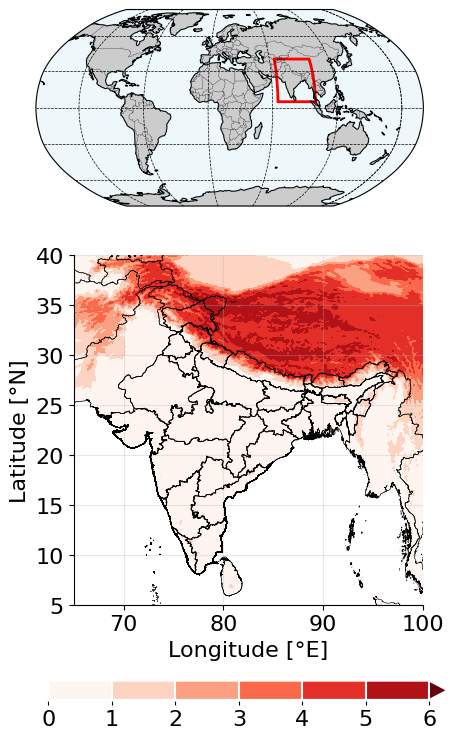

In [4]:
# Creating the figure
fig = plt.figure(figsize=(5, 5))

# Adding subplot with global map
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=20.0))
ax.set_global()
ax.coastlines(lw=0.7)
ax.add_feature(cfeature.BORDERS, linestyle='-', lw=0.2)
ax.add_feature(cfeature.LAND, color='gray', alpha=0.4)
ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)

# Add latitude and longitude grid lines
gl = ax.gridlines(draw_labels=False, linestyle='--', color='k', lw=0.5)

# Define extent of case study regions
regions = {
    "India": [65, 100, 5, 40],
    "Italy": [6, 19, 35, 49],
    "Japan": [122, 149, 30, 48]
}

# Function for adding sub-map
def add_inset(extent, loc, orography, levels, ax_to_hide):

    # Cutting orography in the right extent
    orog = orography.sel(latitude = slice(extent[3], extent[2]), longitude = slice(extent[0], extent[1]))

    # Creating ax for sub map
    sub_ax = fig.add_axes(loc)

    # Plotting orography in submap
    orog_plot = orog.plot(ax=sub_ax, add_colorbar=False, levels=levels, cmap='Reds', extend='max')


    sub_ax.set_title('')


    standard_format_single(orog_plot, country_boundary, world_boundary, True)

    # Aggiungi un box sulla mappa globale per indicare la regione zoomata
    rect = Rectangle((extent[0], extent[2]), extent[1] - extent[0], extent[3] - extent[2],
                     linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
    ax.add_patch(rect)

    sub_ax.set_xlim(extent[0], extent[1])
    sub_ax.set_ylim(extent[2], extent[3])

    sub_ax.set_xlabel('Longitude [°E]')
    sub_ax.set_ylabel('Latitude [°N]')


# Aggiungi le sotto-mappe per ciascuna regione
add_inset(regions["India"], [0.15, -0.8, 0.8, 1], orography, [0,1,2,3,4,5,6], ['top','right'])
# add_inset(regions["Italy"], [0.27, 0.70, 0.6, 0.6], orography, [0,1,2,3], ['bottom', 'left'])
# add_inset(regions["Japan"], [1.07, 0.2, 0.6, 0.6], orography, [0,1,2,3], ['bottom', 'left'])


plt.show()